# Fase 4: Busca de Parâmetros

Nesta fase iremos aprofundar a busca de hiperparamewtros, variabndo os parametros ca cada modelos, e compaerandos seus resultados

O primeiro passo que iremos fazer é importar as bibliotecas principais, e estabelecer o ambiente de execução.


In [1]:
# Bibliotecas Externas
import os
import warnings
import pandas as pd
import numpy as np
import pickle

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

# Ignorando Warnings
warnings.filterwarnings("ignore")

# Bibliotecas Locais
os.chdir("../..")

# Definido Variáveis globais
N_SPLITS = 5
RANDOM_STATE = 51

## 0. Funções Base

In [2]:
def plot_confusion_matrix(cm, title="Matriz de Confusão"):
    cm = np.array(cm)  # Garante que a matriz esteja no formato correto

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[str(i) for i in range(len(cm))],
                yticklabels=[str(i) for i in range(len(cm))])

    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [3]:
def plot_roc_curve(fpr, tpr, auc_score, title="Curva ROC"):
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatório')
    plt.xlabel("FPR (Taxa de Falsos Positivos)")
    plt.ylabel("TPR (Taxa de Verdadeiros Positivos)")
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
def get_model_metrics(model, model_name, X_train, Y_train, X_val, Y_val, X_test, Y_test):
    # Avaliação dos modelos e adição ao DataFrame
    print(f"🔍 Avaliando modelo {model_name}...")

    # Previsões
    Y_pred_train = model.predict(X_train)
    Y_pred_val = model.predict(X_val)
    Y_pred_test = model.predict(X_test)

    # Probabilidades para AUC-ROC
    Y_prob_train = model.predict_proba(X_train)[:, 1]
    Y_prob_val = model.predict_proba(X_val)[:, 1]
    Y_prob_test = model.predict_proba(X_test)[:, 1]

    # Curva ROC
    fpr_train, tpr_train, _ = roc_curve(Y_train, Y_prob_train)
    fpr_val, tpr_val, _ = roc_curve(Y_val, Y_prob_val)
    fpr_test, tpr_test, _ = roc_curve(Y_test, Y_prob_test)

    # Matriz de Confusão
    cm_train = confusion_matrix(Y_train, Y_pred_train)
    cm_val = confusion_matrix(Y_val, Y_pred_val)
    cm_test = confusion_matrix(Y_test, Y_pred_test)

    # Salvando resultados no DataFrame
    df_results = pd.DataFrame([
        {
            "Data": "Train",
            "Accuracy": accuracy_score(Y_train, Y_pred_train),
            "F1_Score": f1_score(Y_train, Y_pred_train),
            "Recall": recall_score(Y_train, Y_pred_train),
            "Precision": precision_score(Y_train, Y_pred_train),
            "AUC_ROC": roc_auc_score(Y_train, Y_prob_train),
            "Confusion_Matrix": [cm_train],
            "FPR": [fpr_train],
            "TPR": [tpr_train]
        },
        {
            "Data": "Validation",
            "Accuracy": accuracy_score(Y_val, Y_pred_val),
            "F1_Score": f1_score(Y_val, Y_pred_val),
            "Recall": recall_score(Y_val, Y_pred_val),
            "Precision": precision_score(Y_val, Y_pred_val),
            "AUC_ROC": roc_auc_score(Y_val, Y_prob_val),
            "Confusion_Matrix": [cm_val],
            "FPR": [fpr_val],
            "TPR": [tpr_val],
        },
        {
            "Data": "Test",
            "Accuracy": accuracy_score(Y_test, Y_pred_test),
            "F1_Score": f1_score(Y_test, Y_pred_test),
            "Recall": recall_score(Y_test, Y_pred_test),
            "Precision": precision_score(Y_test, Y_pred_test),
            "AUC_ROC": roc_auc_score(Y_test, Y_prob_test),
            "Confusion_Matrix": [cm_test],
            "FPR": [fpr_test],
            "TPR": [tpr_test]
        }
    ])

    return df_results

## 1. Importando os Dados

Nosso primero é coletar os dados que preparamos na etapa anterior, para verificar como esses dados se comportam

In [5]:
# Conjunto de treino
X_train = pd.read_csv('./data/processed/X_train.csv')
Y_train = pd.read_csv('./data/processed/Y_train.csv')

Y_train['class'] = Y_train['class'].apply(lambda val: 1 if val == 'UP' else 0)

# Conjunto de validação
X_val = pd.read_csv('./data/processed/X_val.csv')
Y_val = pd.read_csv('./data/processed/Y_val.csv')


Y_val['class'] = Y_val['class'].apply(lambda val: 1 if val == 'UP' else 0)

# Conjunto de teste
X_test = pd.read_csv('./data/processed/X_test.csv')
Y_test = pd.read_csv('./data/processed/Y_test.csv')

Y_test['class'] = Y_test['class'].apply(lambda val: 1 if val == 'UP' else 0)

## 2. Algoritmos de Machine Learning para Classificação

### 2.1 Comitê de Redes Neurais (Sem busca de Hiperparâmetros)

In [6]:
# Definição das redes neurais com diferentes hiperparâmetros
mlp1 = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', random_state=RANDOM_STATE)
mlp2 = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='sgd', random_state=RANDOM_STATE)
mlp3 = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', solver='lbfgs', random_state=RANDOM_STATE)
mlp4 = MLPClassifier(hidden_layer_sizes=(200,), activation='logistic', solver='adam', random_state=RANDOM_STATE)
mlp5 = MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', solver='sgd', random_state=RANDOM_STATE)

In [7]:
# Criando o comitê com votação majoritária
voting_clf = VotingClassifier(estimators=[
    ('mlp1', mlp1),
    ('mlp2', mlp2),
    ('mlp3', mlp3),
    ('mlp4', mlp4),
    ('mlp5', mlp5)
], voting='soft')

In [8]:
# Treinando o comitê
voting_clf.fit(X_train, Y_train.values.ravel())

VotingClassifier(estimators=[('mlp1',
                              MLPClassifier(hidden_layer_sizes=(50,),
                                            random_state=51)),
                             ('mlp2',
                              MLPClassifier(activation='tanh', random_state=51,
                                            solver='sgd')),
                             ('mlp3',
                              MLPClassifier(hidden_layer_sizes=(50, 50),
                                            random_state=51, solver='lbfgs')),
                             ('mlp4',
                              MLPClassifier(activation='logistic',
                                            hidden_layer_sizes=(200,),
                                            random_state=51)),
                             ('mlp5',
                              MLPClassifier(activation='tanh',
                                            hidden_layer_sizes=(100, 50),
                                            random_state=51, solver='sgd'))],
                 voting='soft')

In [9]:
# Avaliando o modelo treinado
df_base_results = get_model_metrics(voting_clf, "CLF", X_train, Y_train, X_val, Y_val, X_test, Y_test)

🔍 Avaliando modelo CLF...


In [10]:
df_base_results

,Data,Accuracy,F1_Score,Recall,Precision,AUC_ROC,Confusion_Matrix,FPR,TPR
0,Train,0.752420,0.668177,0.596543,0.759363,0.824000,"[[[9822, 1542], [3291, 4866]]]","[[0.0, 0.0, 0.0, 8.799718409010911e-05, 8.7997...","[[0.0, 0.0001225940909648155, 0.02341547137427..."
1,Validation,0.746832,0.664555,0.594671,0.753051,0.811340,"[[[2075, 344], [715, 1049]]]","[[0.0, 0.0, 0.0, 0.00041339396444811904, 0.000...","[[0.0, 0.0005668934240362812, 0.03231292517006..."
2,Test,0.758126,0.673759,0.612185,0.749104,0.821446,"[[[2127, 350], [662, 1045]]]","[[0.0, 0.0, 0.0, 0.0004037141703673799, 0.0004...","[[0.0, 0.0005858230814294083, 0.00995899238429..."


### Matriz de confusão

Treino

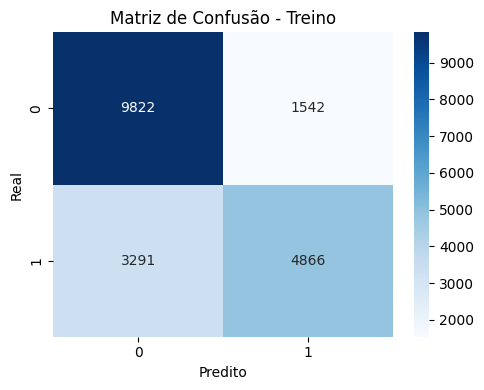

In [11]:
# Exibir as matrizes para cada conjunto
plot_confusion_matrix(df_base_results.loc[0, "Confusion_Matrix"][0], "Matriz de Confusão - Treino")

Validação

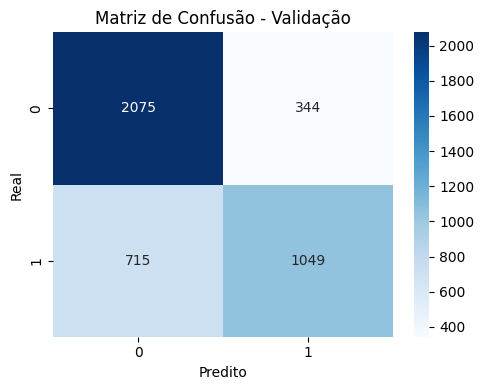

In [12]:
plot_confusion_matrix(df_base_results.loc[1, "Confusion_Matrix"][0], "Matriz de Confusão - Validação")

Teste

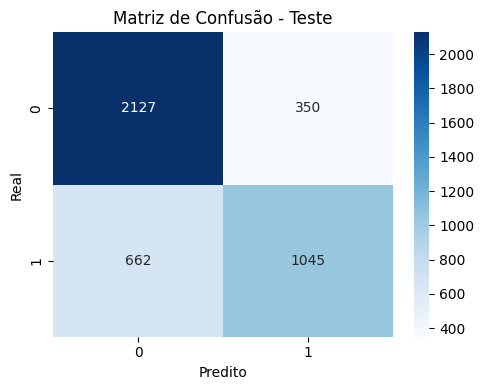

In [13]:
plot_confusion_matrix(df_base_results.loc[2, "Confusion_Matrix"][0], "Matriz de Confusão - Teste")

### Curva ROC

Treino

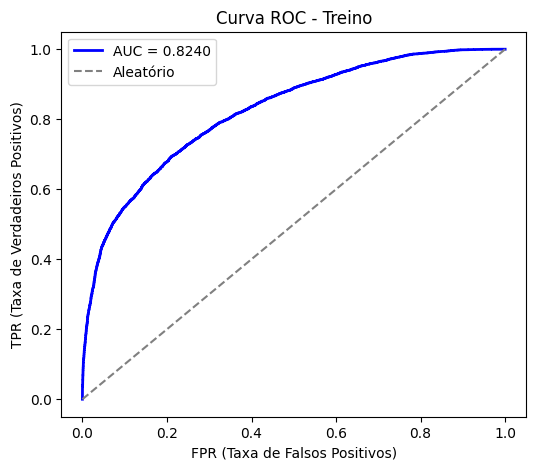

In [14]:
plot_roc_curve(
    df_base_results.loc[0, "FPR"][0], 
    df_base_results.loc[0, "TPR"][0],
    df_base_results.loc[0, "AUC_ROC"],
    "Curva ROC - Treino"
)

Validação

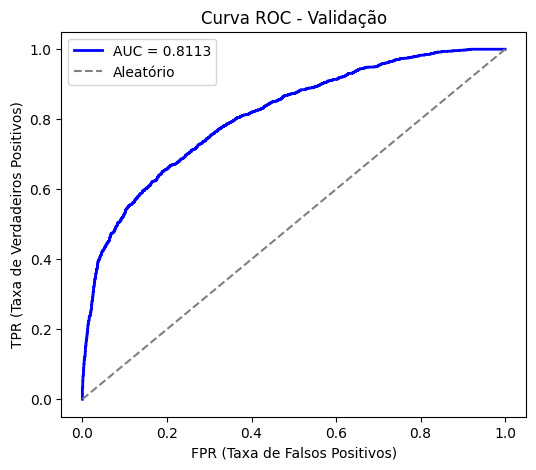

In [15]:
plot_roc_curve(
    df_base_results.loc[1, "FPR"][0],
    df_base_results.loc[1, "TPR"][0],
    df_base_results.loc[1, "AUC_ROC"],
    "Curva ROC - Validação"
)

Teste

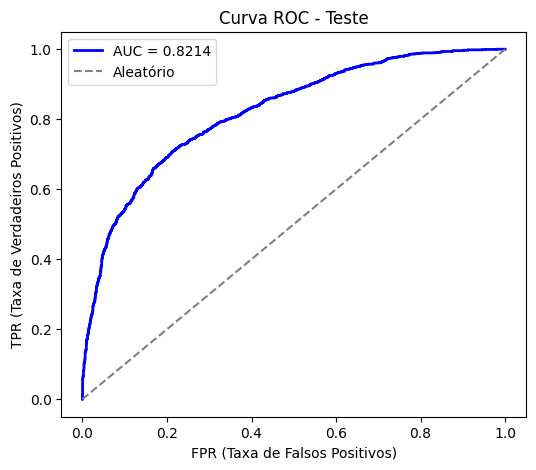

In [16]:
plot_roc_curve(
    df_base_results.loc[2,"FPR"][0],
    df_base_results.loc[2, "TPR"][0],
    df_base_results.loc[2, "AUC_ROC"],
    "Curva ROC - Teste"
)

### 2.2 Comitê de Redes Neurais (Com busca de Hiperparâmetros)

In [17]:
# Definição do espaço de busca para os hiperparâmetros
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (200,), (100, 50), (150,), (75, 75), (300,), (50, 100, 50)],
    'activation': ['relu', 'tanh', 'logistic', 'identity'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': uniform(0.0001, 0.1),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': randint(200, 1000)
}

In [18]:
mlp_checkpoint = './models/mlp_comittee.pkl'
history_checkpoint = './data/results/mlp_comittee.pkl'

In [19]:
# Verifica se há um checkpoint salvo
if os.path.exists(mlp_checkpoint) and os.path.exists(history_checkpoint):
    with open(mlp_checkpoint, "rb") as f:
        best_mlps = pickle.load(f)
    with open(history_checkpoint, "rb") as f:
        performance_history = pickle.load(f)
    start_iter = len(best_mlps)
else:
    best_mlps = []
    performance_history = []
    start_iter = 0

    # Aplicando RandomizedSearchCV para encontrar os melhores parâmetros para cada MLP
    for i in range(start_iter, 5):
        cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE+i)
        
        print(f"Execução {i+1}")
        mlp = MLPClassifier(random_state=RANDOM_STATE+i)
        rand_search = RandomizedSearchCV(mlp, param_dist, n_iter=20, cv=cv_strategy, n_jobs=-1, random_state=RANDOM_STATE+i, return_train_score=True)
        rand_search.fit(X_train, Y_train.values.ravel())

        # Armazenar histórico de desempenho
        mean_test_scores = rand_search.cv_results_['mean_test_score']
        std_test_scores = rand_search.cv_results_['std_test_score']
        performance_history.append((mean_test_scores, std_test_scores))

        best_mlps.append(('mlp' + str(i+1), rand_search.best_estimator_))
        print(f"mlp {i+1} salvo")

        # Salvar progresso no Google Drive
        with open('./models/mlp_comittee.pkl', "wb") as f:
            pickle.dump(best_mlps, f)
        with open('./data/results/mlp_comittee.pkl', "wb") as f:
            pickle.dump(performance_history, f)

In [20]:
model_path = './models/nn_comittee.pkl'

if os.path.exists(model_path):
    with open(model_path, "rb") as f:
        voting_clf = pickle.load(f)
else:
    # Criando o comitê com votação majoritária
    voting_clf = VotingClassifier(estimators=best_mlps, voting='soft')
    
    # Treinando o comitê
    voting_clf.fit(X_train, Y_train.values.ravel())

    # Salvando o modelo treinado
    with open(model_path, "wb") as f:
        pickle.dump(voting_clf, f)

In [22]:
# Avaliando o modelo treinado
df_final_results = get_model_metrics(voting_clf, "CLF", X_train, Y_train, X_val, Y_val, X_test, Y_test)

🔍 Avaliando modelo CLF...


In [23]:
df_final_results

,Data,Accuracy,F1_Score,Recall,Precision,AUC_ROC,Confusion_Matrix,FPR,TPR
0,Train,0.800061,0.738703,0.676352,0.813717,0.884798,"[[[10101, 1263], [2640, 5517]]]","[[0.0, 0.0, 0.0, 8.799718409010911e-05, 8.7997...","[[0.0, 0.0001225940909648155, 0.04866985411303..."
1,Validation,0.790342,0.727893,0.664966,0.803975,0.869005,"[[[2133, 286], [591, 1173]]]","[[0.0, 0.0, 0.0, 0.00041339396444811904, 0.000...","[[0.0, 0.0005668934240362812, 0.05045351473922..."
2,Test,0.795889,0.729576,0.674868,0.793935,0.873698,"[[[2178, 299], [555, 1152]]]","[[0.0, 0.0, 0.0, 0.0004037141703673799, 0.0004...","[[0.0, 0.0005858230814294083, 0.05506736965436..."


### Matriz de confusão

Treino

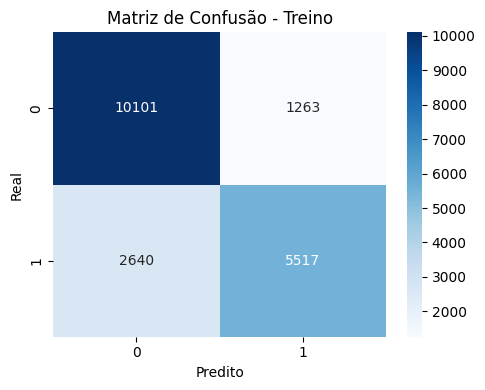

In [24]:
plot_confusion_matrix(df_base_results.loc[0, "Confusion_Matrix"][0], "Matriz de Confusão - Treino")

Validação

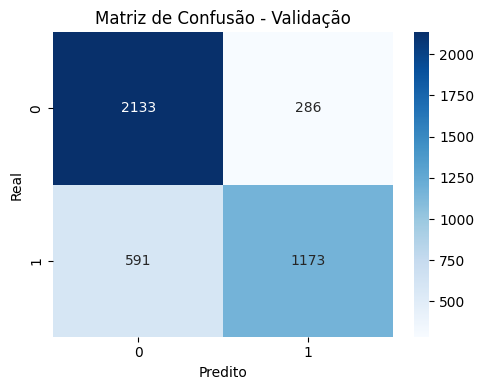

In [25]:
plot_confusion_matrix(df_base_results.loc[1, "Confusion_Matrix"][0], "Matriz de Confusão - Validação")

Teste

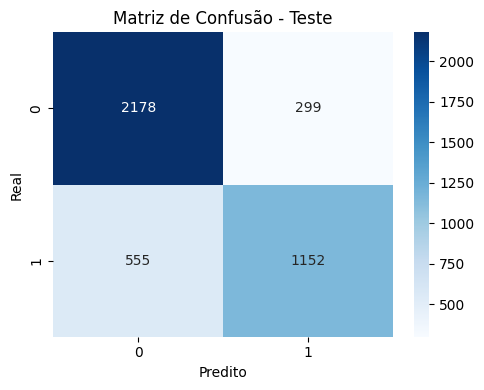

In [26]:
plot_confusion_matrix(df_base_results.loc[2, "Confusion_Matrix"][0], "Matriz de Confusão - Teste")

### Curva ROC

Treino

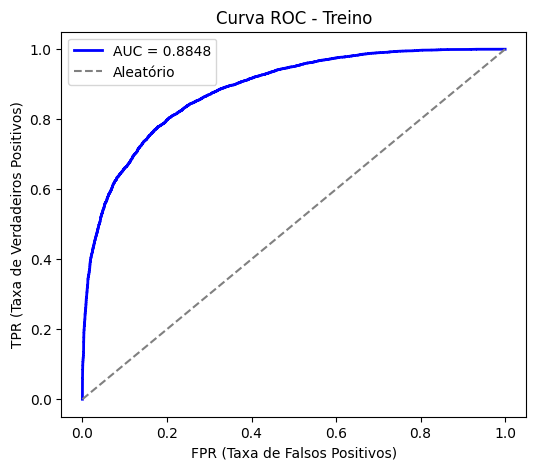

In [27]:
plot_roc_curve(
    df_base_results.loc[0, "FPR"][0], 
    df_base_results.loc[0, "TPR"][0],
    df_base_results.loc[0, "AUC_ROC"],
    "Curva ROC - Treino"
)

Validação

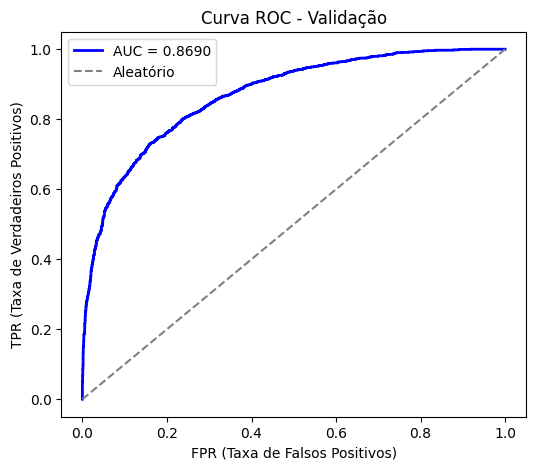

In [28]:
plot_roc_curve(
    df_base_results.loc[1, "FPR"][0],
    df_base_results.loc[1, "TPR"][0],
    df_base_results.loc[1, "AUC_ROC"],
    "Curva ROC - Validação"
)

Teste

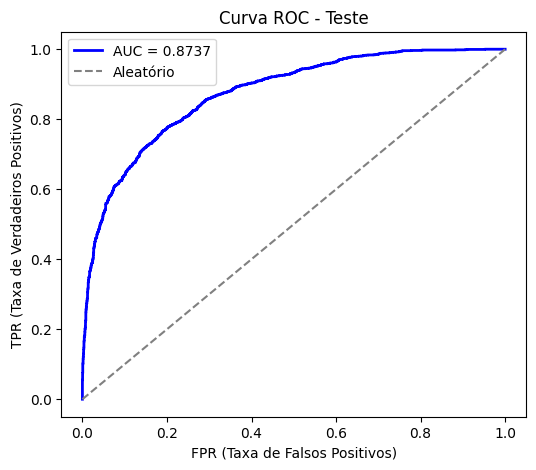

In [29]:
plot_roc_curve(
    df_base_results.loc[2,"FPR"][0],
    df_base_results.loc[2, "TPR"][0],
    df_base_results.loc[2, "AUC_ROC"],
    "Curva ROC - Teste"
)